In [1]:
import scipy
import refnx
import numpy as np
from refnx.reflect import SLD, ReflectModel
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Objective, Transform, CurveFitter
import pandas as pd
import math

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, VBox, HBox, Output
from refnx.reflect import SLD, Structure, Slab


In [106]:
#Load dataset form Alex's notebook
def loadRefData(path, x_start=None, x_end=None):
    data = pd.read_csv(path)  # load text
    if x_start is None:
        x_start = 0
    if x_end is None:
        x_end = len(data)
    x = data['tth'][x_start:x_end]
    y = data['Normalized'][x_start:x_end].map(lambda x : x / data['Normalized'].max())
    # conv t-th to q using 0.72769 A wavelength
    x_new = x.map(lambda x: refnx.util.q(x / 2, 0.72769))
    compiled = (x_new, y)

    return ReflectDataset(compiled)

In [107]:
loadRefData

<function __main__.loadRefData(path, x_start=None, x_end=None)>


# Functions

In [105]:
print(
    f"refnx: {refnx.version.version}\n"
    f"scipy: {scipy.version.version}\n"
    f"numpy: {np.version.version}\n"
)

import pandas as pd
import numpy as np

def round_to_sig_figs(x, sig_figs):
    if x == 0:
        return 0
    else:
        return np.round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)

def format_scientific(x):
    return "{:.4e}".format(x)
    
def generate_table(data):
    thk = np.round(data['thk'], 1)/10
    rough = np.round(data['rough'], 1)/10
    sld = np.round(data['sld'], 1)
    
    # Create a DataFrame from the provided data
    df = pd.DataFrame({
        'Layer': data['layers'],
        'Thickness (nm)': thk,
        'Roughness (nm)': rough,
        'SLD (10^-6 cm^-2)': sld
    })
    
    additional_params = pd.DataFrame({
        'Parameter': ['Chisq', 'Background', 'DQ - Resolution', 'Q Offset'],
        'Value': [format_scientific(round_to_sig_figs(data['chisq'], 4)), 
                  format_scientific(round_to_sig_figs(data['bkg'], 4)), 
                  format_scientific(round_to_sig_figs(data['dq - resolution'], 4)), 
                  format_scientific(round_to_sig_figs(data['q_offset'], 4))]
    })
    
    # Print the main table
    print("Layer Properties:")
    print(df.to_string(index=False))
    
    # Print additional parameters
    print("\nAdditional Parameters:")
    print(additional_params.to_string(index=False))

def check_rng(par):
    if par.value > 0.96 * par.bounds.ub: 
        print(f"Warning: {par.name} is at the upper edge of its bounds \n")
    if par.value < 1.04 * par.bounds.lb:
        print(f"Warning: {par.name} is at the lower edge of its bounds \n")


def process_objective(obj): 
    thk =[]
    rough =[]
    sld = []
    lays = []
    for i in range(1,len(obj.parameters[1])):
        check_rng(obj.parameters[1][i][0])
        check_rng(obj.parameters[1][i][2])
        check_rng(obj.parameters[1][i][1][0])
        lays.append(obj.parameters[1][i].name)
        rough.append(obj.parameters[1][i][2].value)
        thk.append(obj.parameters[1][i][0].value)
        sld.append(obj.parameters[1][i][1][0].value)

    params = {'layers':lays, 'thk':thk, 'rough':rough, 'sld':sld, 'chisq':obj.chisqr()}

    for item in params:
        params[item]=np.array(params[item])

    for i in range(1,len(obj.parameters[0])):
        params[obj.parameters[0][i].name] = obj.parameters[0][i].value
    
    return params 

def save_fig(fig, path, name):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    path_out = os.path.splitext(path)[0] + "_" + name + "_" + timestr+ ".png"
    fig.savefig(path_out)
    return str(path_out)

def save_text(string, path, name):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    path_out = os.path.splitext(path)[0] + "_" + name + "_" + timestr + ".txt"
    text_file = open(path_out, "w")
    text_file.write(string)
    text_file.close()
    return str(path_out)

def standalone_xerr(x, factor):
    # Calculate theta in radians
    wavelength = 0.72769
    theta_radians = 2 * np.arcsin((x * wavelength) / (4 * np.pi))
    # Convert to degrees
    cot = 1 / np.tan(theta_radians)
    x_err = cot/factor
    print ("Error at" ,(theta_radians[-1] *180/np.pi) ," is" , x_err[-1] , "%")
    
    return x_err
    
    
def loadRefData2(path, x_start, x_end, coef, use_err=True):
    data = np.loadtxt(path)  # load text
    x = data[x_start:x_end, 0].T
    y = data[x_start:x_end, 1].T
    y = y/max(y)
    x_new = refnx.util.q(x / 2, 0.72769)
    if use_err:
        y_err = y
        x_err = 0.05*x#coef / np.tan(x*np.pi/360) 
        compiled = (x_new, y, y_err, x_err)
        print (x_err)
    else:
        compiled = (x_new, y)
    return ReflectDataset(compiled)


def simplePlot(x,y,s1,s2):
    plt.loglog(x, y)
    plt.xlabel(s1)
    
    ax.plot(x,y)
    ax.set(xlabel=s1, ylabel=s2)
    plt.show()
    return fig, ax


def plotOut(x,y,s1,s2):
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.set(xlabel=s1, ylabel=s2)
    plt.show()
    return fig, ax

refnx: 0.1.51
scipy: 1.13.1
numpy: 1.26.4



# Plot data 

(0.04, 1)

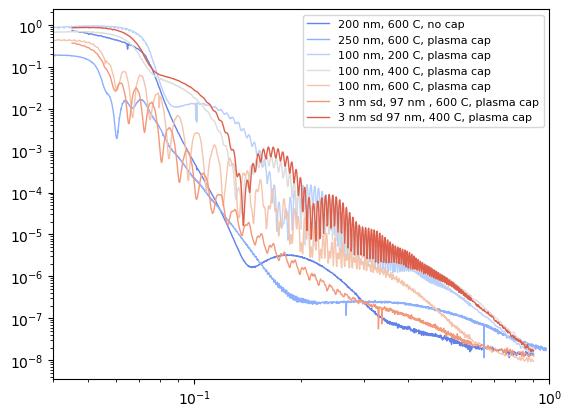

In [126]:
#Load data
import seaborn as sns 
sns.set_palette("coolwarm", 7)
data_list = ['S042_XRR06_stitched',
             'S049_XRR07_run1_XRRstitched.csv',
             'S052_XRR01_run1_XRRstitched.csv',
             'S053_XRR02_run1_XRRstitched.csv',
             'S054_XRR03_run1_XRRstitched.csv',
             'S055_XRR04_stitched',
             'S056_XRR05_stitched']
desc = ['200 nm, 600 C, no cap', 
         '250 nm, 600 C, plasma cap', 
         '100 nm, 200 C, plasma cap', 
         '100 nm, 400 C, plasma cap', 
         '100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', 
         '3 nm sd 97 nm, 400 C, plasma cap']

for d, de in zip(data_list, desc):
    data = loadRefData(d, x_start=150)
    #plt.loglog(data.x, data.y, label=d[0:4], linewidth=1)
    plt.loglog(data.x, data.y, label=de, linewidth=1)
plt.legend(fontsize=8)
plt.xlim([0.04, 1])
# data = loadRefData('S042_XRR06_run3_XRRstitched.csv', x_start=0)

# #data = loadRefData('S049_XRR07_run1_XRRstitched.csv', x_start =150)

# #data = loadRefData('S052_XRR01_run1_XRRstitched.csv', x_start =190)
# #data = loadRefData('S053_XRR02_run1_XRRstitched.csv', x_start =150)
# #data = loadRefData('S054_XRR03_run1_XRRstitched.csv', x_start =150)
# data = loadRefData('S055_XRR04_stitched', x_start=150)
# data = loadRefData('S056_XRR05_stitched', x_start=150)




(0.04, 1)

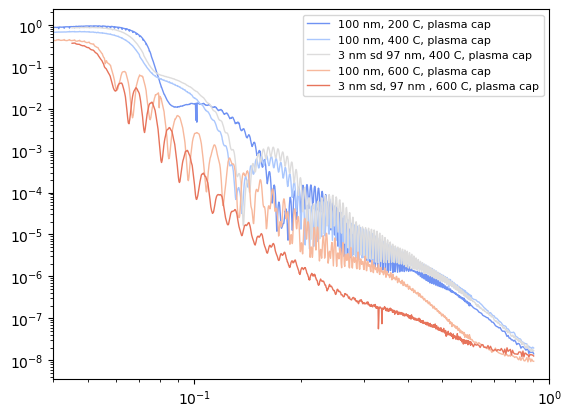

In [130]:
#Load data
import seaborn as sns 
sns.set_palette("coolwarm", 5)
data_list = ['S052_XRR01_run1_XRRstitched.csv',
             'S053_XRR02_run1_XRRstitched.csv',
             'S056_XRR05_stitched',
             'S054_XRR03_run1_XRRstitched.csv',
             'S055_XRR04_stitched']
desc = ['100 nm, 200 C, plasma cap', 
         '100 nm, 400 C, plasma cap', 
         '3 nm sd 97 nm, 400 C, plasma cap',
         '100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]

for d, de in zip(data_list, desc):
    data = loadRefData(d, x_start=150)
    #plt.loglog(data.x, data.y, label=d[0:4], linewidth=1)
    plt.loglog(data.x, data.y, label=de, linewidth=1)
plt.legend(fontsize=8)
plt.xlim([0.04, 1])

In [13]:
SLD_dict = {
    "si": 19.83 + 0.104j,
    "nbf": 40.83 + 0.104j,
    "sio2": 18.709 + 0.054j,
    "ta": 112.93 + 10.71j,
    "ta2o5": 59.37 + 4.42j
}

In [ ]:
#Manual Changes
# Helper to create a layer with sliders
def create_layer_widget(name, sld_real, sld_imag, thick, rough, sld_bounds, thick_bounds, rough_bounds, vary_sld=True):
    thick_slider = widgets.FloatSlider(value=thick, min=thick_bounds[0], max=thick_bounds[1], step=1, description=f'{name} thick')
    rough_slider = widgets.FloatSlider(value=rough, min=rough_bounds[0], max=rough_bounds[1], step=0.1, description=f'{name} rough')
    sld_slider = widgets.FloatSlider(value=sld_real, min=sld_bounds[0], max=sld_bounds[1], step=0.1, description=f'{name} SLD', disabled=not vary_sld)
    sld_imag_slider = widgets.FloatSlider(value=sld_imag, min=0, max=20, step=0.01, description=f'{name} iSLD')
    return VBox([thick_slider, rough_slider, sld_slider, sld_imag_slider]), (thick_slider, rough_slider, sld_slider, sld_imag_slider)

# Layer definitions (example: Si, SiO2, Ta, Ta2O5, Air)

# "Layer Name", SLD real, SLD imag, thickness (A), roughness (A), SLD bounds (real), thickness bounds (A), roughness bounds (A), vary SLD (bool)
layer_defs = [
    ("Air", 0, 0, 0, 0, (0, 0), (0, 0), (0, 0), False),
    ("Ta2O5", SLD_dict['ta2o5'].real, SLD_dict['ta2o5'].imag, 30, 0, (30, 60), (5, 500), (0, 100), True),
    ("Ta", SLD_dict['ta'].real, SLD_dict['ta'].imag, 1000, 0, (100, 120), (0, 1100), (0, 50), True),
    ("SiO2", SLD_dict['sio2'].real, SLD_dict['sio2'].imag, 700, 0, (5, 30), (0, 900), (0, 50), True),
    ("Si", SLD_dict['si'].real, SLD_dict['si'].imag, np.inf, 0, (5, 30), (15, np.inf), (0, 50), False),
]

#    ("Ta2O5", SLD_dict['ta2o5'].real, SLD_dict['ta2o5'].imag, 30, 0, (30, 60), (5, 200), (0, 15), True),
#     ("Si", SLD_dict['si'].real, SLD_dict['si'].imag, np.inf, 0, (5, 30), (15, 1200), (0, 15), False),
# ("SiO2", SLD_dict['sio2'].real, SLD_dict['sio2'].imag, 700, 0, (5, 30), (0, 900), (0, 15), True),
layer_widgets = []
layer_sliders = []
for args in layer_defs:
    w, sliders = create_layer_widget(*args)
    layer_widgets.append(w)
    layer_sliders.append(sliders)

output = Output()

def plot_model(*slider_vals):
    # Unpack slider values for each layer
    idx = 0
    layers = []
    for i, args in enumerate(layer_defs):
        thick = slider_vals[idx]
        rough = slider_vals[idx+1]
        sld_real = slider_vals[idx+2]
        sld_imag = slider_vals[idx+3]
        idx += 4
        sld = SLD(sld_real + 1j * sld_imag, name=args[0])
        layers.append(sld(thick, rough))
    structure = layers[0]
    for layer in layers[1:]:
        structure |= layer
    # Plot
    with output:
        output.clear_output(wait=True)
        # Plot reflectivity if model is available
        try:
            model = ReflectModel(structure, bkg=3e-8, dq=2.5, scale=1)
            q = np.linspace(0.02, 1, 1001)
            plt.figure(figsize=(6,4))
            plt.loglog(q, model(q), label="Model")
            plt.loglog(data.x, data.y, label="Data")
            plt.xlabel("Q")
            plt.ylabel("Reflectivity")
            plt.legend()
            plt.show()
        except Exception as e:
            print("Error plotting reflectivity:", e)
def on_button_click(b):
    plot_model(*[s.value for s in all_sliders])

# Flatten all sliders for interactive
all_sliders = [s for sliders in layer_sliders for s in sliders]
ui = VBox(layer_widgets)
interactive_plot = interactive(plot_model, **{f'slider_{i}': s for i, s in enumerate(all_sliders)})
plot_button = widgets.Button(description = 'Plot')

display(ui, plot_button, output)
interactive_plot.update()
plot_button.on_click(on_button_click)
#interactive_plot.observe(lambda change: plot_model(*[s.value for s in all_sliders]), names='result')


Button(description='Plot', style=ButtonStyle())

Output()

IndexError: tuple index out of range

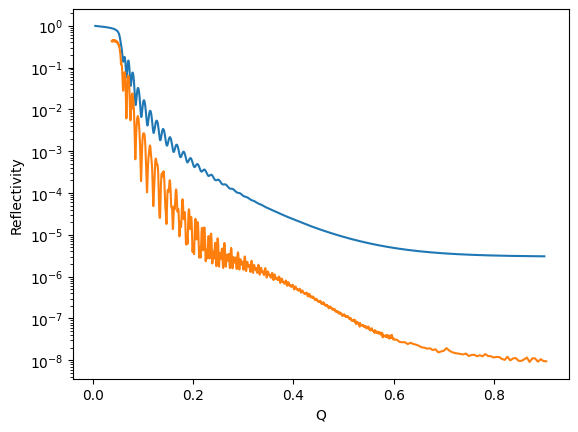

In [196]:
si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 2)
sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(50, 10)
ta_layer = SLD(SLD_dict['ta'], name='Ta')(619, 2)
ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(437, 2)
air_layer = SLD(0, name='Air')(0, 0)

si_layer.rough.setp(bounds = (0, 100), vary = True)

ta_layer.rough.setp(bounds = (0,50), vary = True)
ta_layer.thick.setp(bounds = (300, 500), vary = True)

ta2o5_layer.rough.setp(bounds = (0,50), vary = True)
ta2o5_layer.thick.setp(bounds = (500, 700), vary = True)

sio2_layer.rough.setp(bounds = (0,50), vary = True)
sio2_layer.thick.setp(bounds = (0, 100), vary = True)

structure = air_layer | ta2o5_layer | ta_layer | sio2_layer | si_layer

model = ReflectModel(structure, bkg=3e-6, dq=5.0)
model.scale.setp(bounds=(0.6, 1.2), vary=True)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)

q = np.linspace(0.005, 0.9, 2001)
plt.plot(q, model(q))
plt.xlabel("Q")
plt.ylabel("Reflectivity")
plt.yscale("log")
plt.plot(data.x, data.y)


In [ ]:
sio2_layer

Slab(Parameter(value=50.0, name='Si - thick', vary=True, bounds=Interval(lb=0.0, ub=100.0), constraint=None), SLD([Parameter(value=18.709, name='Si - sld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.054, name='Si - isld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)], name='Si'), Parameter(value=10.0, name='Si - rough', vary=True, bounds=Interval(lb=0.0, ub=50.0), constraint=None), name='Si', vfsolv=Parameter(value=0.0, name='Si - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None)

In [74]:
SLD_dict

{'si': (19.83+0.104j),
 'sio2': (18.709+0.054j),
 'ta': (112.93+10.71j),
 'ta2o5': (59.37+4.42j)}

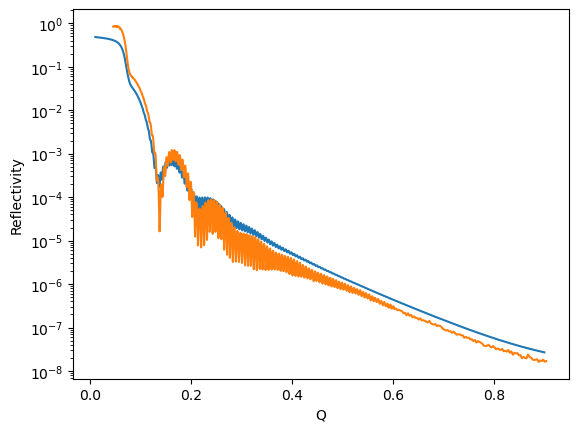

In [ ]:
si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(50, 5)
ta_layer = SLD(SLD_dict['ta'], name='Ta')(1000, 2)
ta2_layer = SLD(SLD_dict['ta'], name='Ta')(800, 5)
m_layer = SLD(SLD_dict['ta'], name='TaSi')(100, 3)
ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(77,9)
air_layer = SLD(0, name='Air')(0, 0)

si_layer.rough.setp(bounds = (0, 10), vary = True)

ta_layer.rough.setp(bounds = (0,10), vary = True)
ta_layer.thick.setp(bounds = (400, 1300), vary = True)
ta_layer.sld.real.setp(bounds = (80,120), vary = True)

ta2_layer.rough.setp(bounds = (0,10), vary = True)
ta2_layer.thick.setp(bounds = (500, 1000), vary = True)
ta2_layer.sld.real.setp(bounds = (80,130), vary = True)

ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

sio2_layer.rough.setp(bounds = (0,25), vary = True)
sio2_layer.thick.setp(bounds = (0, 100), vary = True)
sio2_layer.sld.real.setp(bounds = (10,40), vary = True)

m_layer.rough.setp(bounds = (0,25), vary = True)
m_layer.thick.setp(bounds = (20, 100), vary = True)
m_layer.sld.real.setp(bounds = (20,100), vary = True)
#structure = air_layer | ta_layer | si_layer

structure = air_layer | ta2o5_layer | ta_layer | m_layer | sio2_layer | si_layer
#structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

model = ReflectModel(structure, bkg=1.3e-8, dq=1, scale=0.5, q_offset=0.0)
model.scale.setp(bounds=(0.45, 1.4), vary=True)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)
model.dq.setp(bounds=(0.01,4), vary=True)
model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

q = np.linspace(0.01, 0.9, 10001)

plt.plot(q, model(q))
plt.xlabel("Q")
plt.ylabel("Reflectivity")
plt.yscale("log")
plt.plot(data.x, data.y)


In [88]:
objective = Objective(model, data, transform=Transform("logY"))
fitter = CurveFitter(objective)
fitter.fit("differential_evolution")

0.76891051151845: : 444it [07:26,  1.01s/it]  


             message: Optimization terminated successfully.
             success: True
                 fun: 0.76891051151845
                   x: [ 1.153e+00  7.890e-09 ...  2.444e+01  8.253e+00]
                 nit: 444
                nfev: 116265
          population: [[ 1.153e+00  7.890e-09 ...  2.444e+01  8.253e+00]
                       [ 1.145e+00  9.058e-09 ...  2.333e+01  9.500e+00]
                       ...
                       [ 1.139e+00  7.682e-09 ...  2.110e+01  8.505e+00]
                       [ 1.161e+00  8.425e-09 ...  2.263e+01  8.269e+00]]
 population_energies: [ 7.689e-01  7.893e-01 ...  7.924e-01  7.928e-01]
               covar: [[ 9.054e-05  1.251e-13 ...  1.408e-02 -5.531e-04]
                       [ 1.251e-13  2.056e-19 ... -6.233e-10 -3.131e-11]
                       ...
                       [ 1.408e-02 -6.233e-10 ...  3.063e+02  1.064e+01]
                       [-5.531e-04 -3.131e-11 ...  1.064e+01  3.000e+00]]
              stderr: [ 9.515e-03  

Text(0, 0.5, 'logR')

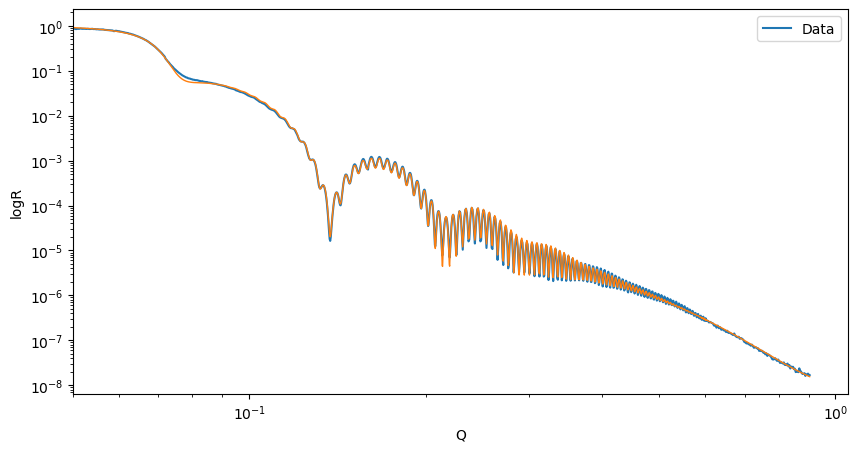

In [89]:
#objective.plot()
plt.figure(figsize=(10,5))
plt.loglog(data.x, data.y, label="Data")
plt.semilogy(objective.data.x, objective.model(objective.data.x), linewidth=1)
plt.legend()
plt.xlim(left=0.05)
plt.xlabel("Q")
plt.ylabel("logR")


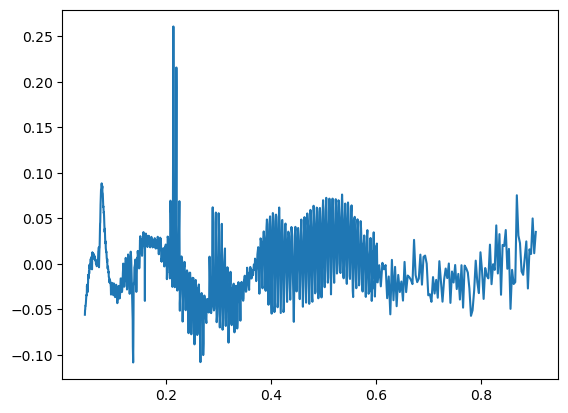

In [90]:
plt.plot(data.x, objective.residuals())

In [92]:
print(objective.parameters)#[0].parameters.data

________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1.15347 +/- 0.00952, bounds=[0.45, 1.4]>
<Parameter:     'bkg'     , value=7.89015e-09 +/- 4.53e-10, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=0.549173 +/- 0.367, bounds=[0.01, 4.0]>
<Parameter:  'q_offset'   , value=-0.00115143 +/- 9.43e-05, bounds=[-0.05, 0.05]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'Air'     
<Parameter:  'Air - sld'  , value=0  (fixed) , bounds=[-inf, inf

In [95]:
a = process_objective(objective)
generate_table(a)

Layer Properties:
Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
Ta205            7.59            0.83               59.9
   Ta          103.92            0.55              108.1
   Ta            2.39            0.22               53.0
 SiO2            6.28            2.44               11.6
   Si             inf            0.83               19.8

Additional Parameters:
      Parameter       Value
          Chisq  1.5380e+00
     Background  7.8900e-09
DQ - Resolution  5.4920e-01
       Q Offset -1.1510e-03


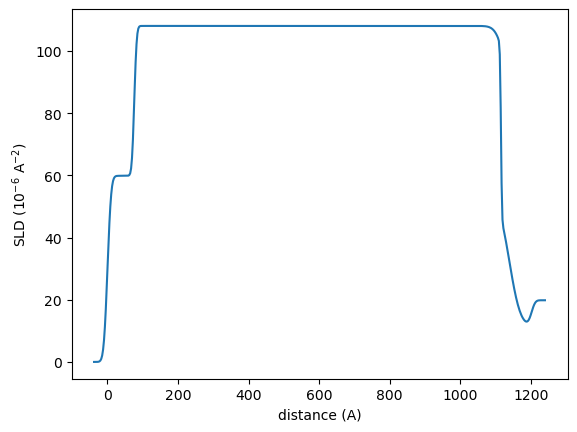

In [ ]:
fig, ax = plotOut(structure.sld_profile()[0], structure.sld_profile()[1], "distance (A)", "SLD ($10^{-6}$ A$^{-2}$)")

# Combo

1.6178275664134472: : 321it [06:41,  1.25s/it]


Layer Properties:
Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
Ta205            5.63            0.72               57.3
   Ta          106.35            0.76              110.8
 TaSi            3.84            0.22               64.8
 SiO2            7.28            0.91               31.3
   Si             inf            0.75               19.8

Additional Parameters:
      Parameter       Value
          Chisq  3.2360e+00
     Background  8.2370e-09
DQ - Resolution  5.6020e-01
       Q Offset -1.0260e-03


0.6294618407805782: : 745it [12:46,  1.03s/it]




Layer Properties:
Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
Ta205            7.86            0.92               61.4
   Ta           95.88            0.58              109.3
 TaSi            9.64            1.88               97.5
 SiO2            1.18            0.21               32.7
   Si             inf            0.47               19.8

Additional Parameters:
      Parameter       Value
          Chisq  1.2590e+00
     Background  4.7350e-09
DQ - Resolution  5.3480e-01
       Q Offset -1.1690e-03


0.6900724149426467: : 1000it [17:21,  1.04s/it]

Layer Properties:
Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
Ta205            7.60            0.83               61.6
   Ta           99.79            0.54              110.4
 TaSi            4.10            1.48               74.0
 SiO2            1.88            0.22               17.9
   Si             inf            0.28               19.8

Additional Parameters:
      Parameter       Value
          Chisq  1.3790e+00
     Background  7.7520e-09
DQ - Resolution  5.5760e-01
       Q Offset -8.4310e-04


Text(0, 0.5, 'logR')

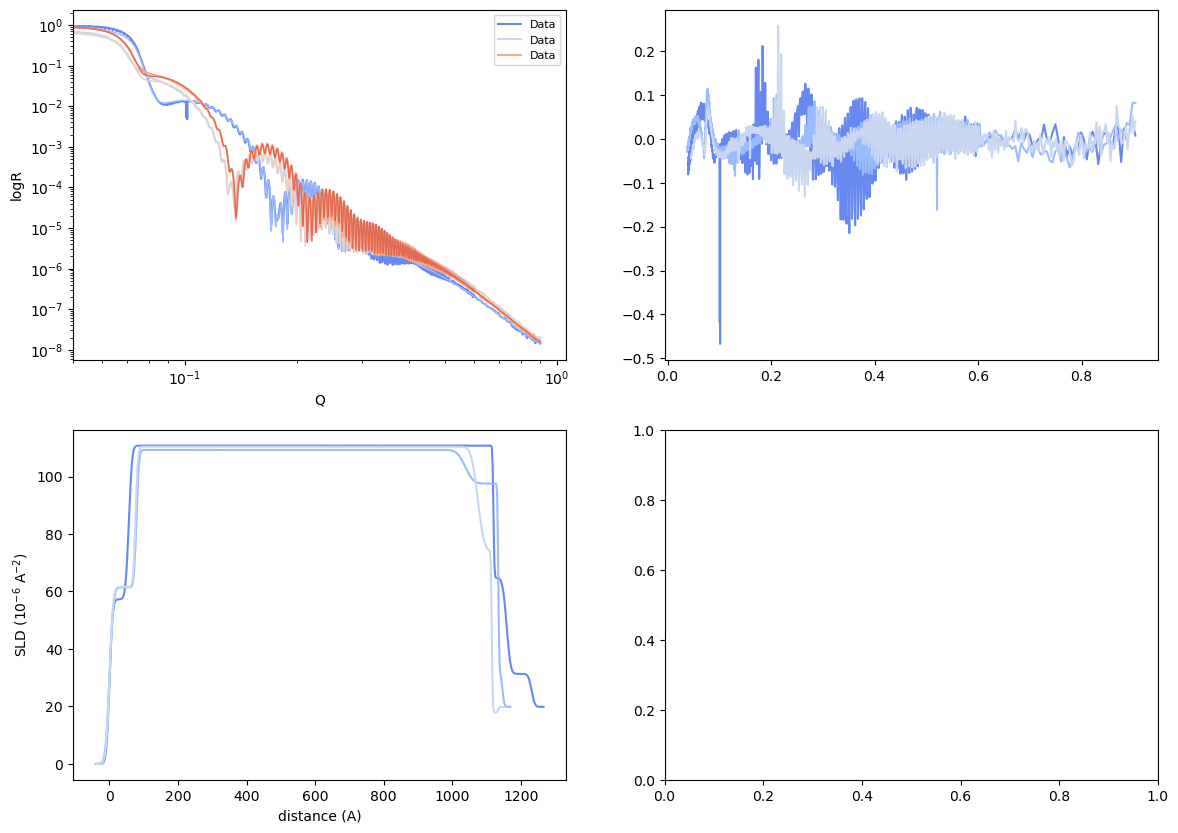

In [ ]:
#Load data
import seaborn as sns 
sns.set_palette("coolwarm", 6)
data_list = ['S052_XRR01_run1_XRRstitched.csv',
             'S053_XRR02_run1_XRRstitched.csv',
             'S056_XRR05_stitched']
            #  'S054_XRR03_run1_XRRstitched.csv',
            #  'S055_XRR04_stitched']
desc = ['100 nm, 200 C, plasma cap', 
         '100 nm, 400 C, plasma cap', 
         '3 nm sd 97 nm, 400 C, plasma cap',
         '100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]


data_list = ['S054_XRR03_run1_XRRstitched.csv',
            'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]

fig, ax = plt.subplots(2, 2, figsize=(14,10))
ax = ax.flatten()
for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(50, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(1000, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(50, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(100, 3)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(77,9)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (400, 1300), vary = True)
    ta_layer.sld.real.setp(bounds = (80,120), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (500, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (80,130), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 100), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=1, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)
    model.dq.setp(bounds=(0.01,4), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    q = np.linspace(0.01, 0.9, 10001)
    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
    ax[0].loglog(data.x, data.y, label=desc[i])
    ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=1)

    ax[1].plot(data.x, objective.residuals())
    a = process_objective(objective)
    generate_table(a)

    ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.05)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")

16.755173560266172: : 184it [03:13,  1.05s/it]




Layer Properties:
Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
Ta205            0.51            1.72               69.8
   Ta           43.61            0.23               83.4
 TaSi            2.47            0.97               20.7
 SiO2            3.01            1.35               21.8
   Si             inf            0.50               19.8

Additional Parameters:
      Parameter      Value
          Chisq 3.3510e+01
     Background 8.3220e-09
DQ - Resolution 6.5910e-01
       Q Offset 1.0710e-02


12.586852208393802: : 354it [06:00,  1.02s/it]





Layer Properties:
Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
Ta205            1.36            2.02               78.0
   Ta          128.26            0.40               80.4
 TaSi           29.24            2.36               46.2
 SiO2            1.17            0.43               33.2
   Si             inf            0.16               19.8

Additional Parameters:
      Parameter      Value
          Chisq 2.5160e+01
     Background 1.1730e-08
DQ - Resolution 7.9760e-01
       Q Offset 1.1370e-02


Text(0, 0.5, 'logR')

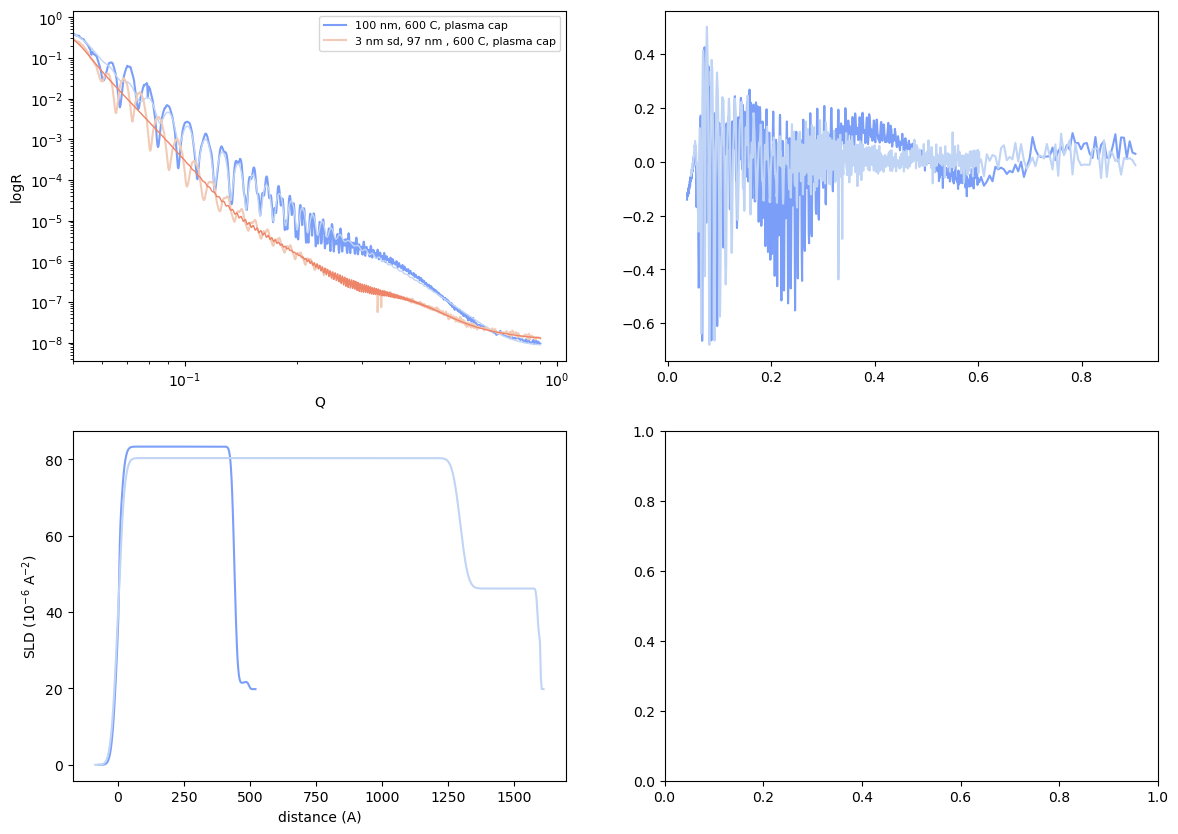

In [143]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv',
            'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]

fig, ax = plt.subplots(2, 2, figsize=(14,10))
ax = ax.flatten()
for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(50, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(500, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(50, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(100, 3)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(77,9)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (400, 1300), vary = True)
    ta_layer.sld.real.setp(bounds = (80,120), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (400, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (80,130), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.3,0.8), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    q = np.linspace(0.01, 0.9, 10001)
    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
    ax[0].loglog(data.x, data.y, label=desc[i])
    ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=1)

    ax[1].plot(data.x, objective.residuals())
    a = process_objective(objective)
    generate_table(a)

    ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.05)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")

7.19564242945082: : 776it [16:37,  1.29s/it]  




Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            0.63            1.51               74.3
    Ta           44.03            0.21               80.1
Ta_bot           87.41            0.87              129.9
  TaSi            3.79            1.17               63.9
  SiO2            2.17            0.37               11.1
    Si             inf            0.42               19.8

Additional Parameters:
      Parameter      Value
          Chisq 1.4390e+01
     Background 1.0330e-08
DQ - Resolution 7.9990e-01
       Q Offset 1.4710e-02


12.251885338928087: : 574it [12:04,  1.26s/it]





Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            1.69            1.94               78.5
    Ta          129.02            0.62               86.9
Ta_bot           98.97            0.82               89.4
  TaSi           28.32            1.22               96.9
  SiO2            2.44            0.29               41.9
    Si             inf            0.85               19.8

Additional Parameters:
      Parameter      Value
          Chisq 2.4490e+01
     Background 1.3610e-08
DQ - Resolution 7.9400e-01
       Q Offset 1.4360e-02


Text(0, 0.5, 'logR')

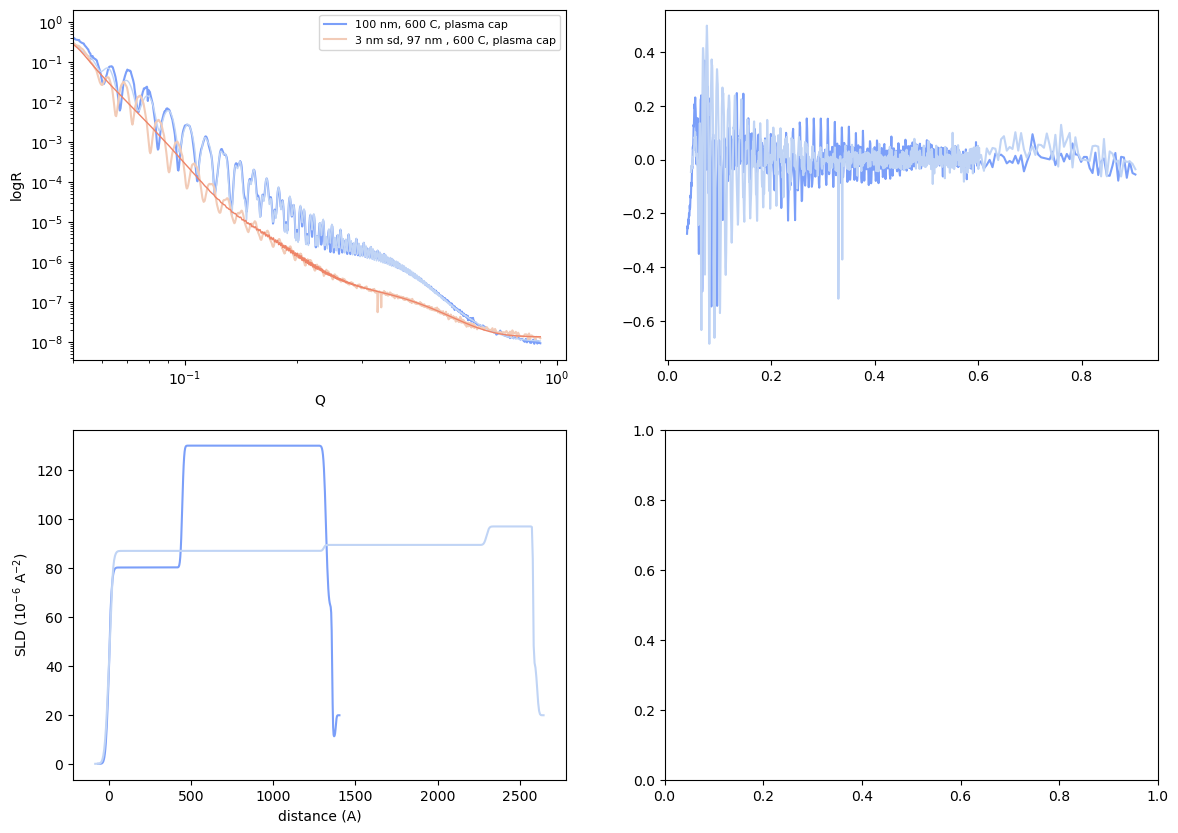

In [144]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv',
            'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]

fig, ax = plt.subplots(2, 2, figsize=(14,10))
ax = ax.flatten()
for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(50, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(500, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(500, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(100, 3)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(77,9)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta_layer.sld.real.setp(bounds = (80,120), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (80,130), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.3,0.8), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    q = np.linspace(0.01, 0.9, 10001)
    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
    ax[0].loglog(data.x, data.y, label=desc[i])
    ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=1)

    ax[1].plot(data.x, objective.residuals())
    a = process_objective(objective)
    generate_table(a)

    ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.05)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")

0it [00:00, ?it/s]

11.197161166366834: : 447it [10:37,  1.43s/it]




Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            0.53            1.62               55.7
    Ta           43.40            0.22               70.1
Ta_bot           86.46            1.00              128.7
  TaSi            4.56            1.14               70.3
  SiO2            3.22            0.39               25.7
    Si             inf            0.38               19.8

Additional Parameters:
      Parameter      Value
          Chisq 2.2390e+01
     Background 8.3320e-09
DQ - Resolution 6.1960e-01
       Q Offset 2.7220e-03


Text(0, 0.5, 'logR')

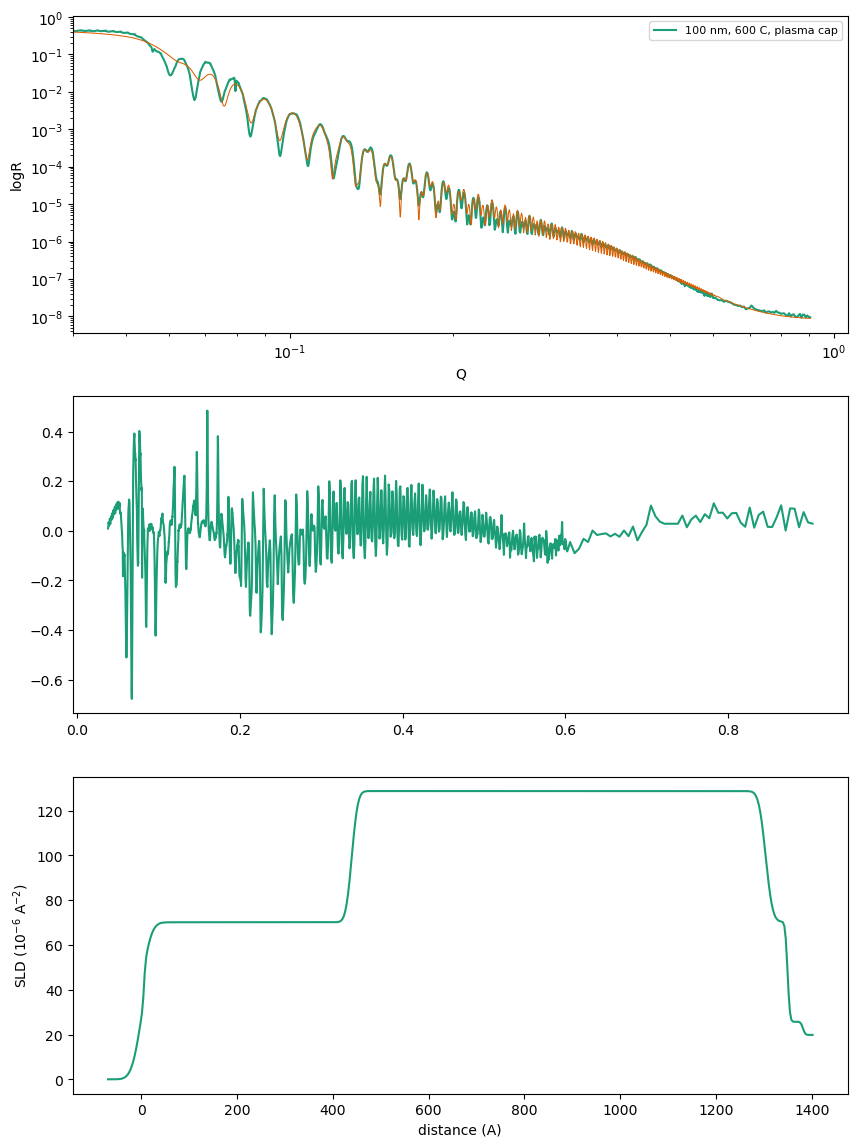

In [154]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv']
           # 'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]


for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(10, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(300, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(750, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(20, 12)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(20,12)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta_layer.sld.real.setp(bounds = (70,110), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (90,140), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.375,0.62), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
sns.set_palette("Dark2")

fig, ax = plt.subplots(3, 1, figsize=(10,14))
ax = ax.flatten()
ax[0].loglog(data.x, data.y, label=desc[i])
ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=0.75)

ax[1].plot(data.x, objective.residuals())
a = process_objective(objective)
generate_table(a)

ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.04)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")

13.263617143950338: : 456it [10:34,  1.39s/it]





Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            0.52            1.63               75.1
    Ta           43.86            0.23               85.1
Ta_bot           65.58            0.88              124.9
  TaSi           19.94            1.85               56.6
  SiO2            6.61            1.71               44.5
    Si             inf            0.37               19.8

Additional Parameters:
      Parameter      Value
          Chisq 2.6490e+01
     Background 9.4810e-09
DQ - Resolution 6.1150e-01
       Q Offset 1.6430e-02


Text(0, 0.5, 'logR')

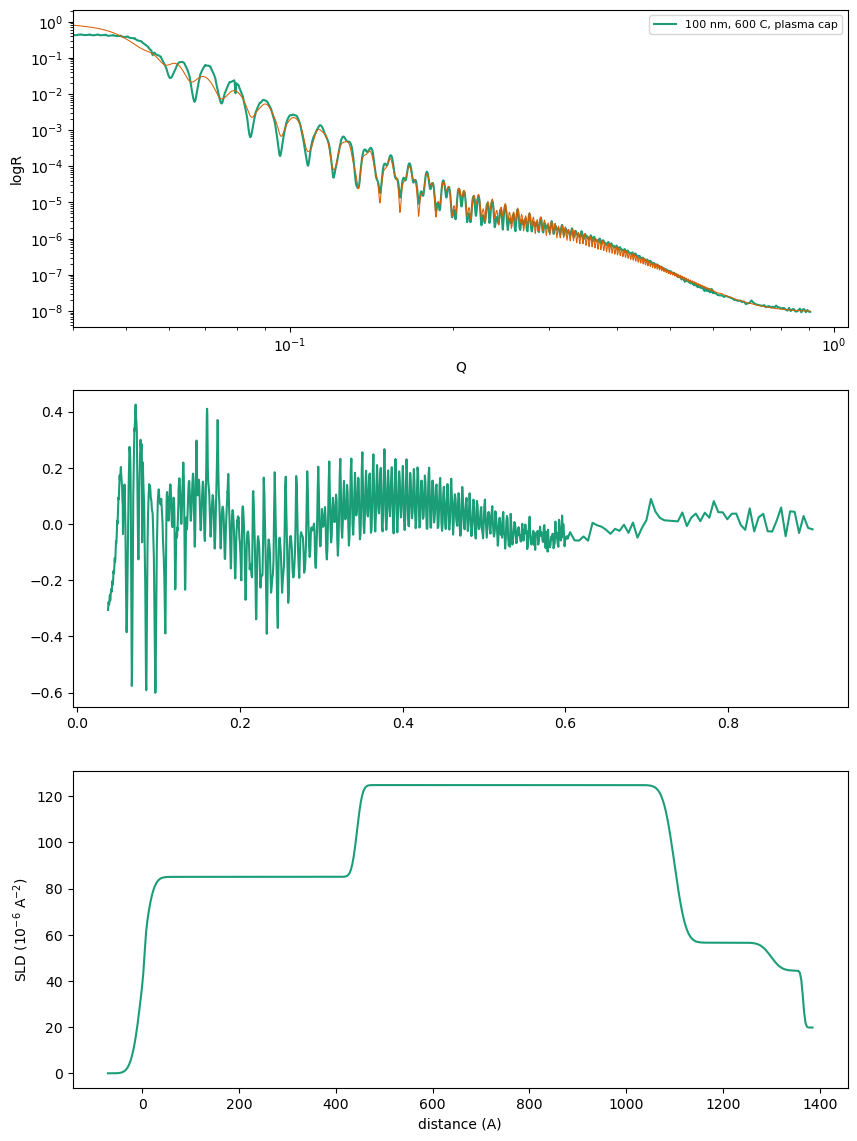

In [155]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv']
           # 'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]


for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(10, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(300, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(750, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(20, 12)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(20,12)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta_layer.sld.real.setp(bounds = (85,110), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (90,125), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.375,0.62), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
sns.set_palette("Dark2")

fig, ax = plt.subplots(3, 1, figsize=(10,14))
ax = ax.flatten()
ax[0].loglog(data.x, data.y, label=desc[i])
ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=0.75)

ax[1].plot(data.x, objective.residuals())
a = process_objective(objective)
generate_table(a)

ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.04)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")

In [ ]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv']
           # 'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]


for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(10, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(300, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_mid')(750, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(20, 12)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(20,12)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta_layer.sld.real.setp(bounds = (70,110), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (90,140), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.375,0.62), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    q = np.linspace(0.01, 0.9, 10001)
    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
sns.set_palette("Dark2")

fig, ax = plt.subplots(3, 1, figsize=(10,14))
ax = ax.flatten()
ax[0].loglog(data.x, data.y, label=desc[i])
ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=0.75)

ax[1].plot(data.x, objective.residuals())
a = process_objective(objective)
generate_table(a)

ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.04)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")



Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            1.67            1.51               46.4
    Ta           44.54            0.81               80.1
Ta_bot           73.54            0.86              130.0
  TaSi           17.65            1.53               93.4
  SiO2            3.73            0.33               40.0
    Si             inf            0.83               19.8

Additional Parameters:
      Parameter      Value
          Chisq 1.2710e+01
     Background 1.0840e-08
DQ - Resolution 6.2410e-01
       Q Offset 1.4130e-02


Text(0, 0.5, 'logR')

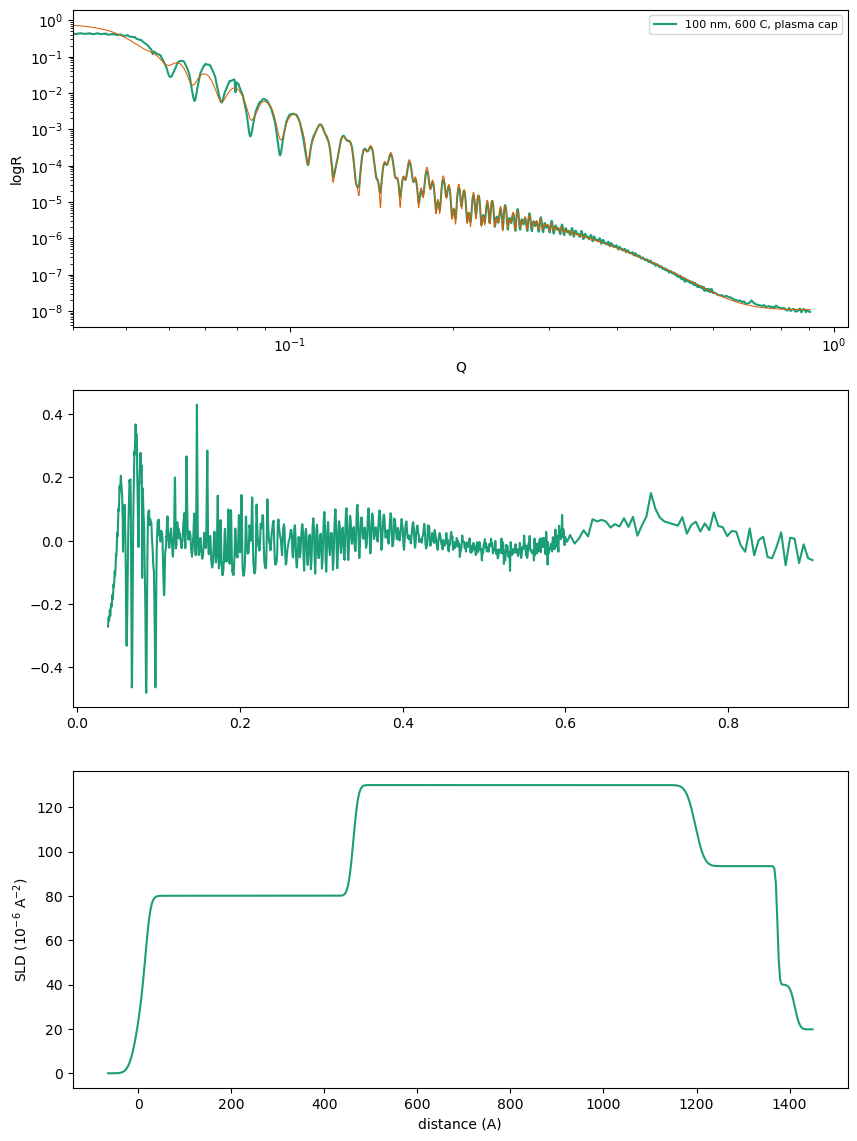

In [137]:
print(objective.parameters)#[0].parameters.data


________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1.00484 +/- 0.0129, bounds=[0.45, 1.4]>
<Parameter:     'bkg'     , value=9.89197e-09 +/- 6.84e-10, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=0.571294 +/- 0.679, bounds=[0.01, 4.0]>
<Parameter:  'q_offset'   , value=-0.0088122 +/- 0.00015, bounds=[-0.05, 0.05]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'Air'     
<Parameter:  'Air - sld'  , value=0  (fixed) , bounds=[-inf, inf]>
